<a href="https://colab.research.google.com/github/Snehaganupa/Snehaganupa/blob/main/phishing_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Detection with Random Forest

In [33]:
!pip install scikit-learn pandas numpy --quiet



In [21]:

import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from scipy.sparse import hstack


In [30]:
df = pd.read_csv("/content/phish_legit_site_urls.csv")
df["label"] = df["Label"].map({"bad": 1, "good": 0})
df.drop(columns=["Label"], inplace=True)
df = df[df["URL"].str.len() > 10]
phish = df[df.label == 1].sample(n=100000, random_state=42)
legit = df[df.label == 0].sample(n=100000, random_state=42)
df_balanced = pd.concat([phish, legit], ignore_index=True).sample(frac=1, random_state=42)
df_balanced.head()

,URL,label
119737,dextremes.com/sega/revs/crusader.html,0
72272,monkeysdragon.net/jhg45s,1
158154,www.cisco.com/en/US/docs/internetworking/techn...,0
65426,swagads.net/,1
30074,ns1.writerworks.biz/,1


In [26]:

def safe_parse(url):
    try:
        if not url.startswith(("http://", "https://")):
            url = "http://" + url
        return urlparse(url)
    except:
        return urlparse("http://invalid.url")

suspicious_words = ['login', 'secure', 'account', 'update', 'free', 'verify', 'bank', 'paypal']

def extract_features(url):
    parsed = safe_parse(url)
    domain = parsed.netloc or ""
    path = parsed.path + parsed.query
    try:
        entropy_val = round(-sum(p * np.log2(p) for p in [float(url.count(c)) / len(url) for c in set(url)] if p > 0), 5)
    except:
        entropy_val = 0
    return {
        "url_length": len(url),
        "domain_length": len(domain),
        "path_length": len(path),
        "num_dots": url.count('.'),
        "num_hyphens": url.count('-'),
        "num_slashes": url.count('/'),
        "num_at": url.count('@'),
        "has_https": int(url.startswith("https")),
        "has_ip": int(bool(re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', domain))),
        "starts_with_ip": int(bool(re.match(r'^(http[s]?://)?(\d{1,3}\.){3}\d{1,3}', url))),
        "contains_suspicious_word": int(any(word in url.lower() for word in suspicious_words)),
        "has_double_slash_redirect": int('//' in path.strip('/')),
        "num_params": url.count('&') + url.count('?'),
        "entropy": entropy_val,
    }

features_df = df_balanced["URL"].apply(extract_features).apply(pd.Series)
features_df["label"] = df_balanced["label"]
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=300)
X_tfidf = tfidf.fit_transform(df_balanced["URL"])
X_smart = features_df.drop(columns=["label"])
X = hstack([X_tfidf, X_smart])
y = features_df["label"]


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [12]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [13]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Legitimate", "Phishing"]))


Accuracy: 0.94115
Precision: 0.9463725589395933
Recall: 0.9353
F1 Score: 0.9408037016546799

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.94      0.95      0.94     20000
    Phishing       0.95      0.94      0.94     20000

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



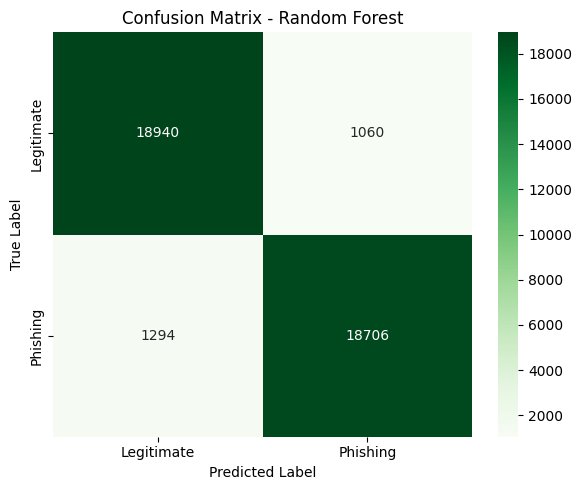

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ["Legitimate", "Phishing"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()
